In [ ]:
import warnings
warnings.filterwarnings("ignore")

#!pip3 install plotly.express
#import sys
#!conda install --yes --prefix {sys.prefix} plotly
#!conda install -c anaconda py-xgboost --yes
#!pip3 install hyperopt
!conda install -c conda-forge hyperopt --yes

### Import Packages and define functions

In [1]:
import multiprocessing as mp
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
sns.set_context('notebook')
sns.set_style('white')
%matplotlib inline

#import utils
from ipywidgets import interact, fixed


from sklearn.svm import LinearSVR, SVR
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
np.random.seed(0)

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score


### EDA and Feature Engineering

In [2]:
# load csv
df = pd.read_csv('train_cleaned.csv',index_col=0)
df.head()

,log_price,property_type,room_type,amenities,internet,air_conditioning,breakfast,parking,kitchen,pool,pets_allowed,checkin_24,tv,laundry,accommodates,bathrooms,bed_type,cancellation_policy,flexible,moderate,strict,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,miles_city_center,cc_latitude,cc_longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,has_thumbnail,zipcode,bedrooms,beds
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",1,1,0,0,1,0,0,0,0,0,3,1.0,Real Bed,strict,0,0,1,1,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",6/18/2016,1.0,1.0,NaN,3/26/2012,0,7/18/2016,40.696524,-73.991617,2.708,40.712743,-74.013380,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,1,11201.0,1.0,1.0
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",1,1,0,0,1,0,0,0,0,1,7,1.0,Real Bed,strict,0,0,1,1,NYC,Enjoy travelling during your stay in Manhattan...,8/5/2017,1.0,0.0,100%,6/19/2017,1,9/23/2017,40.766115,-73.989040,5.882,40.712743,-74.013380,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,1,10019.0,3.0,3.0
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",1,1,1,0,1,0,0,0,1,0,5,1.0,Real Bed,moderate,0,1,0,1,NYC,The Oasis comes complete with a full backyard ...,4/30/2017,1.0,1.0,100%,10/25/2016,1,9/14/2017,40.808110,-73.943756,11.837,40.712743,-74.013380,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,1,10027.0,1.0,3.0
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1,0,0,0,1,0,0,0,1,1,4,1.0,Real Bed,flexible,1,0,0,1,SF,This light-filled home-away-from-home is super...,NaN,1.0,1.0,NaN,4/19/2015,0,NaN,37.772004,-122.431619,3.707,37.795211,-122.402779,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,1,94117.0,2.0,2.0
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",1,1,0,0,1,0,0,0,1,0,2,1.0,Real Bed,moderate,0,1,0,1,DC,"Cool, cozy, and comfortable studio located in ...",5/12/2015,1.0,1.0,100%,3/1/2015,1,1/22/2017,38.925627,-77.034596,2.800,38.897743,-77.036530,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,0,20009.0,0.0,1.0


In [3]:
# create dummies for some variables that should have them
df2 = pd.get_dummies(data=df, columns = ['city', 'room_type', 'property_type'])

# grab the new dummies
df2 = df2.iloc[:, 43::]

In [4]:
# concat into CSV DF
df = pd.concat([df, df2], axis = 1)

# remove string vars
df = df.select_dtypes(exclude=[np.object])

# drop na
df = df.dropna(axis = 0)

# prepare X, y
y = df['log_price'].values
X = df.drop(['log_price'], axis = 1).values

# shuffle data
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, y = X[shuffle], y[shuffle]

# split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state = 42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full, random_state = 42)

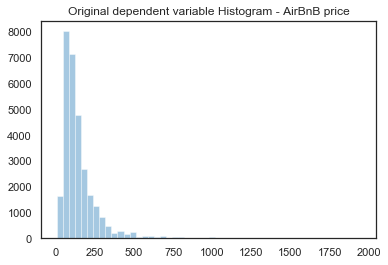

In [5]:
sns.distplot(np.exp(y_train), kde=False)
plt.title('Original dependent variable Histogram - AirBnB price');

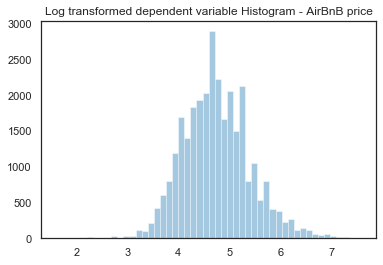

In [6]:
sns.distplot(y_train, kde=False)
plt.title('Log transformed dependent variable Histogram - AirBnB price');

### Nominal Variables

In [7]:
nominal = ['internet','air_conditioning','breakfast','parking','kitchen','pool','pets_allowed',
           'checkin_24','tv','laundry','accommodates','bathrooms','flexible','moderate','strict',
           'cleaning_fee','host_has_profile_pic','host_identity_verified','instant_bookable','longitude',
           'miles_city_center','cc_latitude','cc_longitude','number_of_reviews','review_scores_rating',
           'bedrooms','beds']

df_quant = df[nominal]

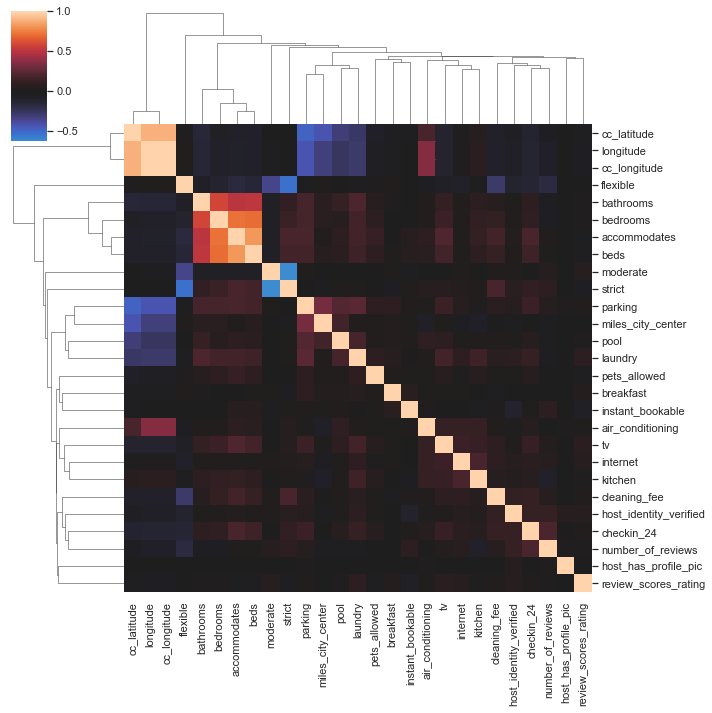

In [8]:
sns.clustermap(df_quant.corr(), center=0)

### Modeling

In [9]:

# scorer
mse = make_scorer(metrics.mean_squared_error)

# functions
# confidence interval
def confidence_interval(confidence_level, predicted_y, y_test):
    confidence = confidence_level
    squared_errors = (predicted_y - y_test) ** 2
    return np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                             loc = squared_errors.mean(),
                             scale = stats.sem(squared_errors)))

# cross val scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", round(scores.mean(), 3))
    print("Standard deviation:", round(scores.std(), 3))


# result storage
model_name = []
RMSE = []
CI = []
cross_val_mean = []

In [10]:

################## Base Model: Linear Regression ##################
# fit a linear regression model
lm = LinearRegression() # instantiate lm
lm.fit(X_train_full, y_train_full); # fit lm
r2_lm = lm.score(X_train_full, y_train_full) # x, y

# show r2 of regression model
print(round(r2_lm, 3), 'is the r-squared for the regression model')

# generate predictions
predicted_y = lm.predict(X_test) # prediction

# metrics
lm_RMSE = mean_squared_error(y_test, predicted_y, squared = False)
print('Root Mean Squared Error:', round(lm_RMSE, 3))

# confidence interval for RMSE
lm_ci = confidence_interval(0.95, predicted_y, y_test)
print('The 95% confidence interval for our RMSE is:', np.round(lm_ci, 3))

# cross-val on dev data
scores = cross_val_score(lm, X_dev, y_dev,
                         scoring = "neg_mean_squared_error", # expects utility fx
                         cv = 10) # 10 folds

rmse_scores = np.sqrt(-scores) # sqrt for RMSE

display_scores(rmse_scores)
# dev data contains some very messed up observations,
# or lm is just struggling to predict,
# as evidenced by cross-val

display_scores(rmse_scores)

# append results
model_name.append('linear model')
RMSE.append(lm_RMSE)
CI.append(lm_ci)
cross_val_mean.append(rmse_scores.mean())

0.663 is the r-squared for the regression model
Root Mean Squared Error: 0.381
The 95% confidence interval for our RMSE is: [0.374 0.387]
Scores: [0.38711925 0.38105801 0.38384291 0.39502018 0.36974067 0.40851729
 0.38387248 0.38465918 0.38743473 0.38689151]
Mean: 0.387
Standard deviation: 0.009
Scores: [0.38711925 0.38105801 0.38384291 0.39502018 0.36974067 0.40851729
 0.38387248 0.38465918 0.38743473 0.38689151]
Mean: 0.387
Standard deviation: 0.009


### HyperOpt parameterization for XGBoost https://mlwhiz.com/blog/2017/12/28/hyperopt_tuning_ml_model/

In [16]:
def objective(space):
    print(space)
    clf = xgb.XGBRegressor(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                            learning_rate = .05,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            n_jobs=12,
                            gamma = space['gamma'],
                            reg_lambda = space['reg_lambda'],)

    eval_set  = [( X_train_full, y_train_full), ( X_dev, y_dev)]

    clf.fit(X_train_full, y_train_full,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(X_dev)
    mse_scr = mean_squared_error(y_dev, pred)
    print ("SCORE:", np.sqrt(mse_scr))
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }


space ={'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best XGB model parameters are", best)

{'colsample_bytree': 0.8421428975172167, 'gamma': 0.36499862692982354, 'max_depth': 4.0, 'min_child_weight': 2.0, 'reg_lambda': 0.8377560455989024, 'subsample': 0.7162267837430448}
[08:03:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                 
0.2971258937269722                                     
{'colsample_bytree': 0.9441352644707404, 'gamma': 0.37986689169098453, 'max_depth': 7.0, 'min_child_weight': 4.0, 'reg_lambda': 0.5051810343355971, 'subsample': 0.7383042537711673}
[08:03:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                            
0.24630337284699672                                                               
{'colsample_bytree': 0.7064360743191398, 'gamma': 0.43668945026215666, 'max_depth': 9.0, 'min_child_weight': 5.0, 'reg_lambda': 

SCORE:                                                                                
0.28247151766795797                                                                   
{'colsample_bytree': 0.7822449657928371, 'gamma': 0.23874905834118892, 'max_depth': 4.0, 'min_child_weight': 9.0, 'reg_lambda': 0.3092953684178944, 'subsample': 0.8953224120905344}
[08:17:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                
0.29824745884839393                                                                   
{'colsample_bytree': 0.9380367181603514, 'gamma': 0.36440705224721026, 'max_depth': 11.0, 'min_child_weight': 8.0, 'reg_lambda': 0.48966558945739724, 'subsample': 0.8781722555244172}
[08:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                  

{'colsample_bytree': 0.9049760114218389, 'gamma': 0.1840339506976511, 'max_depth': 16.0, 'min_child_weight': 7.0, 'reg_lambda': 0.7138407347061815, 'subsample': 0.7848471303840908}
[08:35:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                               
0.1422096847117549                                                                   
{'colsample_bytree': 0.8752571836829511, 'gamma': 0.2230917057734767, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.5940421472635993, 'subsample': 0.735669862832371}
[08:36:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                               
0.21002934952912886                                                                  
{'colsample_bytree': 0.9810663843289167, 'gamma': 0.325000943147

[08:51:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                             
0.2992299546708003                                                                 
{'colsample_bytree': 0.9452684983889819, 'gamma': 0.11811449595030094, 'max_depth': 7.0, 'min_child_weight': 10.0, 'reg_lambda': 0.8251194954680166, 'subsample': 0.8035410013708977}
[08:51:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                             
0.23780279438984517                                                                
{'colsample_bytree': 0.8244661679713322, 'gamma': 0.2971114598643808, 'max_depth': 16.0, 'min_child_weight': 8.0, 'reg_lambda': 0.5487219106997143, 'subsample': 0.9798353361982031}
[08:52:39] WARNING: src/objective/regression_obj.cu:152: reg:linear i

0.12195712857781912                                                                   
{'colsample_bytree': 0.8314668955211177, 'gamma': 0.11874112018219107, 'max_depth': 16.0, 'min_child_weight': 10.0, 'reg_lambda': 0.078746855482482, 'subsample': 0.7258942724345713}
[09:08:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                
0.12094248504118013                                                                   
{'colsample_bytree': 0.826385334384687, 'gamma': 0.17842523590161863, 'max_depth': 14.0, 'min_child_weight': 9.0, 'reg_lambda': 0.234503860002542, 'subsample': 0.7073994252516925}
[09:09:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                
0.14962441690986303                                       

{'colsample_bytree': 0.8822777410579244, 'gamma': 0.3204058535505922, 'max_depth': 10.0, 'min_child_weight': 6.0, 'reg_lambda': 0.15356519683625658, 'subsample': 0.7525781982204307}
[09:26:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                
0.2035162023552113                                                                    
{'colsample_bytree': 0.7238332639475846, 'gamma': 0.374272710994556, 'max_depth': 15.0, 'min_child_weight': 4.0, 'reg_lambda': 0.34401884288202844, 'subsample': 0.78115025787413}
[09:27:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                
0.18615118367468686                                                                   
{'colsample_bytree': 0.8122374214034304, 'gamma': 0.1805601

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] n_estimators=1000, max_depth=2, learning_rate=0.1707120635769804, gamma=3.2295213206652176, alpha=1.0433706268137974 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, max_depth=2, learning_rate=0.1707120635769804, gamma=3.2295213206652176, alpha=1.0433706268137974, total=   2.8s
[CV] n_estimators=1000, max_depth=2, learning_rate=0.1707120635769804, gamma=3.2295213206652176, alpha=1.0433706268137974 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  n_estimators=1000, max_depth=2, learning_rate=0.1707120635769804, gamma=3.2295213206652176, alpha=1.0433706268137974, total=   2.9s
[CV] n_estimators=1000, max_depth=2, learning_rate=0.1707120635769804, gamma=3.2295213206652176, alpha=1.0433706268137974 
[CV]  n_estimators=1000, max_depth=2, learning_rate=0.1707120635769804, gamma=3.2295213206652176, alpha=1.0433706268137974, total=   2.7s
[CV] n_estimators=100, max_depth=3, learning_rate=0.4705998377753653, gamma=3.6214952727675565, alpha=2.5386277433501125 
[CV]  n_estimators=100, max_depth=3, learning_rate=0.4705998377753653, gamma=3.6214952727675565, alpha=2.5386277433501125, total=   0.4s
[CV] n_estimators=100, max_depth=3, learning_rate=0.4705998377753653, gamma=3.6214952727675565, alpha=2.5386277433501125 
[CV]  n_estimators=100, max_depth=3, learning_rate=0.4705998377753653, gamma=3.6214952727675565, alpha=2.5386277433501125, total=   0.4s
[CV] n_estimators=100, max_depth=3, learning_rate=0.4705998377753653, gamma=3.62149

[CV]  n_estimators=200, max_depth=2, learning_rate=0.5208344239895681, gamma=1.0535709145542997, alpha=1.3746205169825512, total=   0.6s
[CV] n_estimators=200, max_depth=2, learning_rate=0.5208344239895681, gamma=1.0535709145542997, alpha=1.3746205169825512 
[CV]  n_estimators=200, max_depth=2, learning_rate=0.5208344239895681, gamma=1.0535709145542997, alpha=1.3746205169825512, total=   0.6s
[CV] n_estimators=200, max_depth=2, learning_rate=0.5208344239895681, gamma=1.0535709145542997, alpha=1.3746205169825512 
[CV]  n_estimators=200, max_depth=2, learning_rate=0.5208344239895681, gamma=1.0535709145542997, alpha=1.3746205169825512, total=   0.6s
[CV] n_estimators=300, max_depth=3, learning_rate=0.1367151627045232, gamma=3.246056315197686, alpha=1.5998067575415802 
[CV]  n_estimators=300, max_depth=3, learning_rate=0.1367151627045232, gamma=3.246056315197686, alpha=1.5998067575415802, total=   1.2s
[CV] n_estimators=300, max_depth=3, learning_rate=0.1367151627045232, gamma=3.2460563151

[CV]  n_estimators=700, max_depth=5, learning_rate=0.27614301519066364, gamma=2.002535060379175, alpha=4.070972601326716, total=   3.9s
[CV] n_estimators=700, max_depth=2, learning_rate=0.8872388774395236, gamma=3.4408117683107537, alpha=4.783391782489315 
[CV]  n_estimators=700, max_depth=2, learning_rate=0.8872388774395236, gamma=3.4408117683107537, alpha=4.783391782489315, total=   2.0s
[CV] n_estimators=700, max_depth=2, learning_rate=0.8872388774395236, gamma=3.4408117683107537, alpha=4.783391782489315 
[CV]  n_estimators=700, max_depth=2, learning_rate=0.8872388774395236, gamma=3.4408117683107537, alpha=4.783391782489315, total=   2.0s
[CV] n_estimators=700, max_depth=2, learning_rate=0.8872388774395236, gamma=3.4408117683107537, alpha=4.783391782489315 
[CV]  n_estimators=700, max_depth=2, learning_rate=0.8872388774395236, gamma=3.4408117683107537, alpha=4.783391782489315, total=   2.0s
[CV] n_estimators=200, max_depth=5, learning_rate=0.12880226400673772, gamma=4.22956666766454

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  3.3min finished


[0]	validation_0-rmse:0.451952
Will train until validation_0-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:0.386757
[2]	validation_0-rmse:0.3781
[3]	validation_0-rmse:0.372423
[4]	validation_0-rmse:0.364595
[5]	validation_0-rmse:0.360337
[6]	validation_0-rmse:0.356863
[7]	validation_0-rmse:0.352897
[8]	validation_0-rmse:0.34826
[9]	validation_0-rmse:0.345755
[10]	validation_0-rmse:0.344356
[11]	validation_0-rmse:0.343988
[12]	validation_0-rmse:0.342276
[13]	validation_0-rmse:0.341435
[14]	validation_0-rmse:0.340095
[15]	validation_0-rmse:0.338827
[16]	validation_0-rmse:0.338827
[17]	validation_0-rmse:0.338827
[18]	validation_0-rmse:0.338827
[19]	validation_0-rmse:0.338827
[20]	validation_0-rmse:0.338827
[21]	validation_0-rmse:0.338827
[22]	validation_0-rmse:0.338827
[23]	validation_0-rmse:0.338827
[24]	validation_0-rmse:0.338827
[25]	validation_0-rmse:0.338827
[26]	validation_0-rmse:0.338827
[27]	validation_0-rmse:0.338827
[28]	validation_0-rmse:0.338827
[29]	validation_0-rm

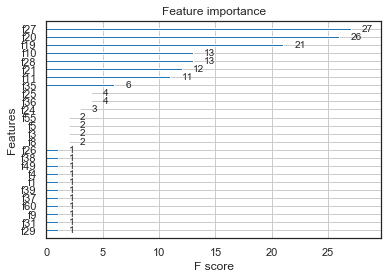

In [13]:


################# XGBoost ########################
# create xgb model
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror', learning_rate = 1,
                max_depth = 2, alpha = 2.67, n_estimators = 100, gamma = 3.80,
                booster = 'gbtree', n_jobs=6)
# set ex-post after grid search

# setup grid search params
params = {'learning_rate' : np.random.uniform(0.1, 1, 100), 'alpha': np.random.uniform(0.5, 5, 100),
 'max_depth' : [2, 3, 4, 5], 'gamma' : np.random.uniform(0.5, 5, 100), 'n_estimators': [100, 200, 300, 400, 500, 700, 1000]}

# grid search the xgboost
rnd_search_cv = RandomizedSearchCV(xgb_reg, params, n_iter = 30, verbose = 2, cv = 3, scoring = mse)

# validate search on dev data
rnd_search_cv.fit(X_dev, y_dev)

# fit again on full data now with best estimator
final_model = rnd_search_cv.best_estimator_

final_model.fit(X_train_full, y_train_full,
            eval_set=[(X_dev, y_dev)],
             early_stopping_rounds = 15)

# generate predictions
predicted_y = final_model.predict(X_test, ntree_limit = final_model.best_iteration)

# metrics
xgboost_RMSE = mean_squared_error(y_test, predicted_y, squared = False)
print('Root Mean Squared Error:', round(xgboost_RMSE, 3))

# confidence interval for RMSE
xgb_ci = confidence_interval(0.95, predicted_y, y_test)
print('The 95% confidence interval for our RMSE is:', np.round(xgb_ci, 3))

# cross-val predictive power on dev data
scores = cross_val_score(final_model, X_dev, y_dev,
                         scoring = "neg_mean_squared_error", # expects utility fx
                         cv = 10) # 10 folds

rmse_scores = np.sqrt(-scores) # sqrt for RMSE

# display cross-validated RMSE
display_scores(rmse_scores)

# append results
model_name.append('xgboost')
RMSE.append(xgboost_RMSE)
CI.append(xgb_ci)
cross_val_mean.append(rmse_scores.mean())


# plot feature importance
xgb.plot_importance(final_model)
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

# get names for feature importance
x_names = df.drop(['log_price'], axis = 1)
x_names = x_names.columns.tolist()

# get dict of important variables
f_importance_dict = final_model.get_booster().get_score()

# order the dict and get top 10
top_10_f = sorted(f_importance_dict, key = f_importance_dict.get, reverse = True)[:10]

# pop 'f' off for matching variable names
top_10_f2 = []
for i in top_10_f:
    top_10_f2.append(int(i[1:]))

# find variable names for 10 top vars
top_10_f_names = []
for index, name in enumerate(x_names):
    if index in top_10_f2:
        top_10_f_names.append(name)

# ['tv', 'accommodates',  'bathrooms',  'latitude',  'longitude',
# 'miles_city_center',  'zipcode',  'bedrooms',  'room_type_Entire home/apt',
# 'room_type_Private room']

# zipcode seems redundant with lat/lon



